# GARCH Stock Forecasting

## Read Data

In [36]:
import numpy as np
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import os


In [2]:
def compute_return(y, r_type="log", h=1):
    
    # exclude first h observations
    y2 = y[h:]
    
    # exclude last h observations
    y1 = y[:-h]
    
    if r_type == "log":
        ret = np.concatenate(([np.nan]*h, 100 * (np.log(y2) - np.log(y1))))
    else:
        ret = np.concatenate(([np.nan]*h, 100 * (y2-y1)/y1))
        
    return ret

## Import Data

In [54]:
start = datetime(2000, 1, 1)
end = datetime(2023, 11, 30)

stock = yf.Ticker("^GDAXI") 
# DIS for disney
# SPY for SnP500
# ^GDAXI for DAX

hist = stock.history(period="max", start=start, end=end)

for i in range(5):
    hist["ret"+str(i+1)] = compute_return(hist["Close"].values, h=i+1)

hist = hist.dropna()
# returns = 100 * hist.Close.pct_change().dropna()

hist = hist.set_index(hist.index.date)
hist.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits,ret1,ret2,ret3,ret4,ret5
2000-01-10,6785.470215,6975.259766,6785.470215,6925.520020,42006200,0.0,0.0,2.109446,6.727690,6.309258,5.012269,2.555809
2000-01-11,6926.040039,6943.830078,6821.259766,6891.250000,43890000,0.0,0.0,-0.496065,1.613381,6.231625,5.813193,4.516204
2000-01-12,6878.919922,6913.500000,6783.220215,6912.810059,34683100,0.0,0.0,0.312373,-0.183692,1.925754,6.543998,6.125566
2000-01-13,6913.129883,7106.450195,6898.689941,6955.979980,48116200,0.0,0.0,0.622550,0.934923,0.438858,2.548304,7.166548
2000-01-14,6960.290039,7207.450195,6960.290039,7173.220215,47040900,0.0,0.0,3.075296,3.697846,4.010219,3.514153,5.623600


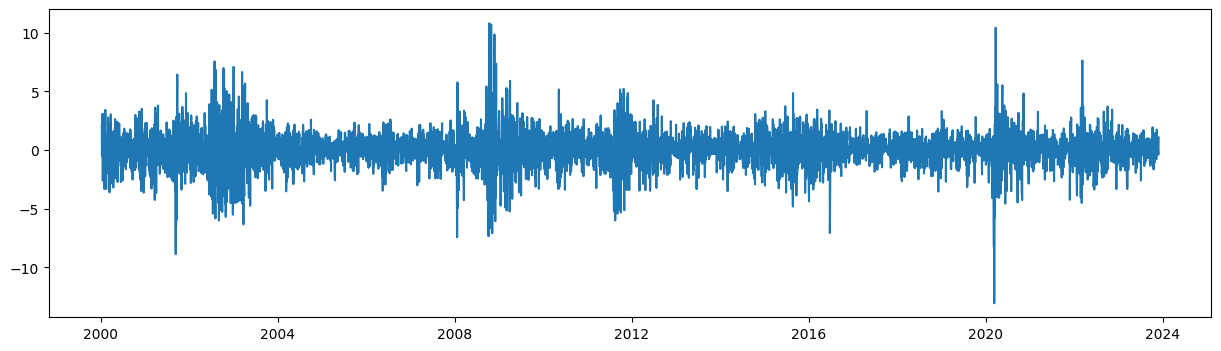

In [12]:
plt.figure(figsize=(15,4))
plt.plot(hist.ret1)
plt.show()

## Look at ACF & PACF

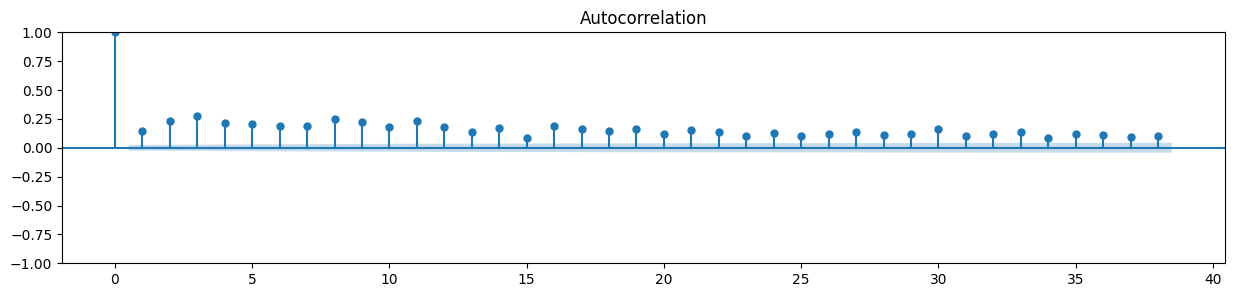

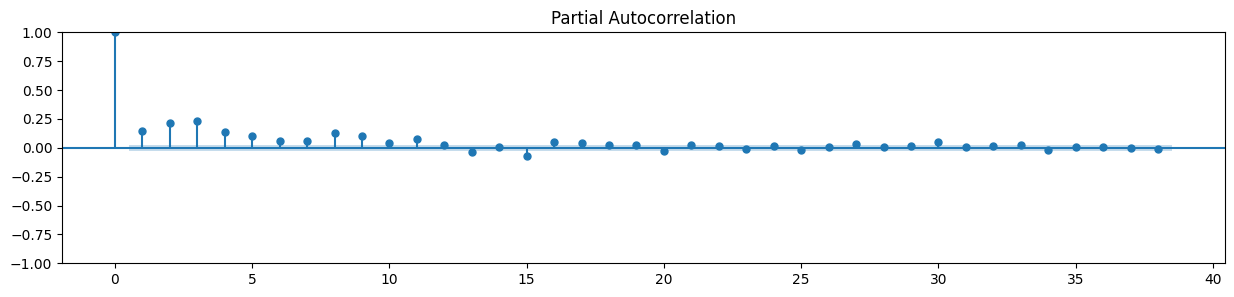

In [15]:
fig, ax = plt.subplots(figsize=(15, 3))
plot_acf(hist.ret1**2, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(15, 3))
plot_pacf(hist.ret1**2, ax=ax)
plt.show()

## Fit Different GARCH Models

In [16]:
# default with to specification is GARCH(1,1)
    # where mean is constant
    # and variance is ARMA(1,1)

am = arch_model(hist.ret1)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     37,   Neg. LLF: 9793.705389536726
Iteration:     10,   Func. Count:     64,   Neg. LLF: 9774.264893799871
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9774.264891083609
            Iterations: 12
            Function evaluations: 73
            Gradient evaluations: 12
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   ret1   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9774.26
Distribution:                  Normal   AIC:                           19556.5
Method:            Maximum Likelihood   BIC:                           19583.4
                                        No. Observations:                 6069
Date:                Sat, Dec 02 2023   Df Residuals:                     6068
Time:          

c:\Users\ytl_c\miniconda3\Lib\site-packages\arch\univariate\base.py:1890: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
c:\Users\ytl_c\miniconda3\Lib\site-packages\arch\univariate\base.py:1891: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
c:\Users\ytl_c\miniconda3\Lib\site-packages\arch\univariate\base.py:1892: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `

In [26]:
rolling_predictions = []
test_size = 600

for i in range(test_size):
    
    # gets all data except last (test_size-i)
    # to predict (test_size-i) th last value
    train = hist.ret1[:-(test_size-i)]

    # fit GARCH(1,1) for each day in year ( ie find new coefficients )
    model = arch_model(train)
    model_fit = model.fit(disp='off')

    # make a one-step prediction and save to rolling_predictions
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

# save rolling_predictions as series with dates for plotting later
rolling_predictions = pd.Series(rolling_predictions, index=hist.index[-test_size:])

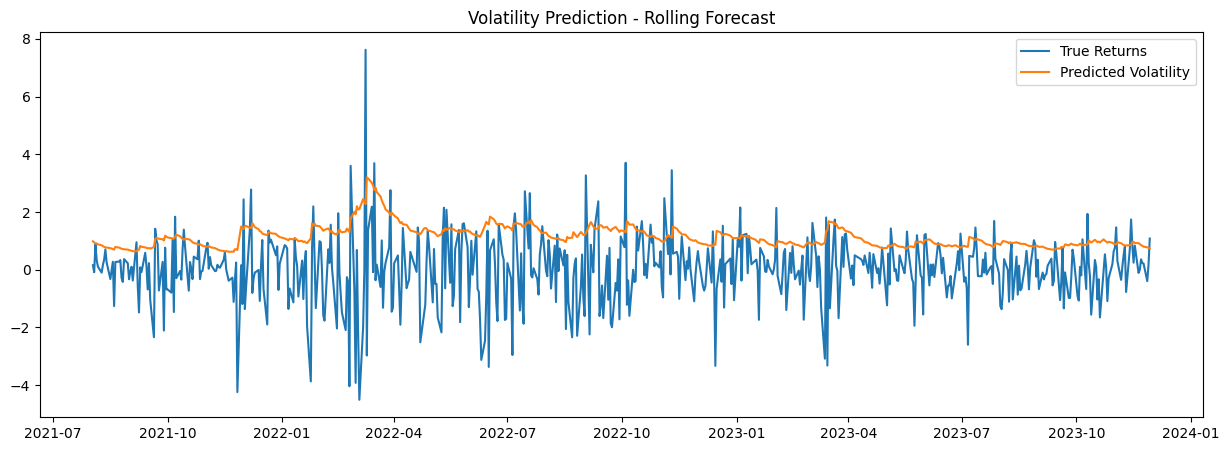

In [28]:
plt.figure(figsize=(15,5))

plt.plot(hist.ret1[-test_size:], label='True Returns')
plt.plot(rolling_predictions, label='Predicted Volatility')

plt.title('Volatility Prediction - Rolling Forecast')
plt.legend()
plt.show()

# Predictions using GARCH(2,2)

In [30]:
train = hist.ret1
model = arch_model(train, p=2, q=2)
model_fit = model.fit(disp='off')

In [32]:
pred = model_fit.forecast(horizon=7)
future_dates = [hist.index[-1] + timedelta(days=i) for i in range(1,8)]
pred_series = pd.Series(np.sqrt(pred.variance.values[0]), index=future_dates)

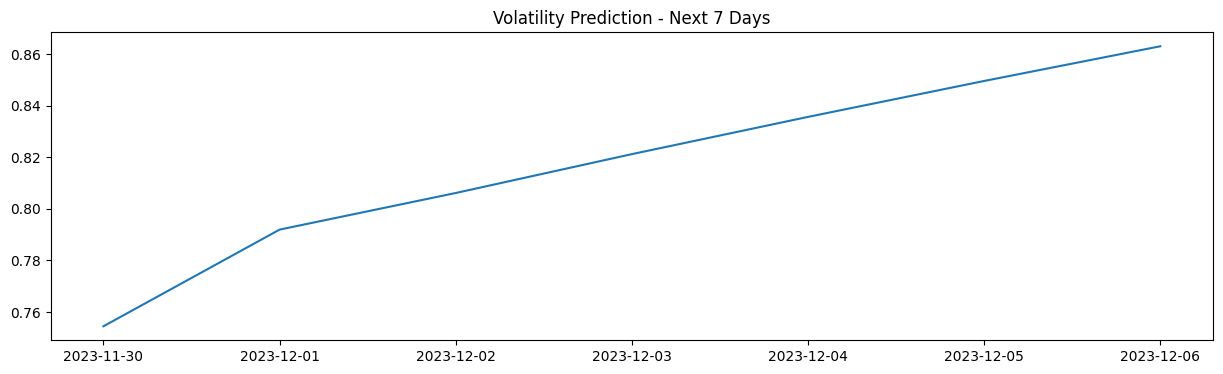

In [33]:
plt.figure(figsize=(15,4))

plt.plot(pred_series)
plt.title('Volatility Prediction - Next 7 Days')

plt.show()